In [18]:
from jqdata import *
import pandas as pd

In [19]:
# 日期
start_date = '2019-01-01'
end_date = '2020-01-01'
# 全A股
stocks = list(get_all_securities(types=['stock'], date=start_date).index)
# 去除3t
stocks= [x for x in stocks if 'ST' not in get_security_info(x, date=start_date).display_name 
         and '*' not in get_security_info(x, date=start_date).display_name 
         and '退' not in get_security_info(x, date=start_date).display_name]

In [20]:
# 获取交易日期
trading_days = get_trade_days(start_date=start_date, end_date=end_date)


In [21]:
#获取申万一级行业
industry_categray = 'sw_l1'
industries=get_industries(industry_categray, date=start_date)
industries=industries['name']
industries=pd.DataFrame(industries)
industries=industries.reset_index()
industries=industries.rename(columns={'name':'industry'})

industry_name_list=['801010_nong_lin_mu_yu','801020_cai_jue','801030_hua_gong',\
              '801040_gang_tie','801050_you_se_jin_shu','801080_dian_zi',\
              '801110_jia_yong_dian_qi','801120_shi_pi_yin_liao','801130_fang_zhi_fu_zhuang',\
              '801140_qing_gong_zhi_zhao','801150_yi_liao_sheng_wu','801160_gong_yong_shi_ye',\
              '801170_jiao_tong_yun_shu','801180_fang_di_chan','801200_shang_ye_mao_yi',\
              '801210_xiu_xian_fu_wu','801230_zhong_he','801710_jian_zhu_cai_liao',\
              '801720_jian_zhu_zhuang_shi','801730_dian_qi_she_bei','801740_guo_fang_jun_gong',\
              '801750_ji_suan_ji','801760_chuan_mei','801770_tong_xin',
              '801780_yin_hang','801790_fei_yin_jin_rong','801880_qi_che',\
              '801890_ji_xie_she_bei'] 
shenwen_df=pd.DataFrame(industry_name_list,columns=['industry_name'])
shenwen_df['index']=shenwen_df['industry_name'].apply(lambda x:x[0:6])
shenwen_df,industries

(                 industry_name   index
 0        801010_nong_lin_mu_yu  801010
 1               801020_cai_jue  801020
 2              801030_hua_gong  801030
 3              801040_gang_tie  801040
 4        801050_you_se_jin_shu  801050
 5               801080_dian_zi  801080
 6      801110_jia_yong_dian_qi  801110
 7       801120_shi_pi_yin_liao  801120
 8    801130_fang_zhi_fu_zhuang  801130
 9    801140_qing_gong_zhi_zhao  801140
 10     801150_yi_liao_sheng_wu  801150
 11     801160_gong_yong_shi_ye  801160
 12    801170_jiao_tong_yun_shu  801170
 13         801180_fang_di_chan  801180
 14      801200_shang_ye_mao_yi  801200
 15       801210_xiu_xian_fu_wu  801210
 16             801230_zhong_he  801230
 17    801710_jian_zhu_cai_liao  801710
 18  801720_jian_zhu_zhuang_shi  801720
 19      801730_dian_qi_she_bei  801730
 20    801740_guo_fang_jun_gong  801740
 21           801750_ji_suan_ji  801750
 22            801760_chuan_mei  801760
 23             801770_tong_xin  801770


In [22]:
# 获取股票所在的行业
stock_industry=get_industry(stocks, date=start_date)
industry=pd.DataFrame(index=['industry'],columns=stocks)

In [23]:
# 获取股票对应的行业
for i in stocks:
    if industry_categray in stock_industry[i]:
        b=stock_industry[i][industry_categray]['industry_name']
        industry[i]=b
industry=industry.T.reset_index()
industry=industry.rename(columns={'index':'code'})
industry.head()
# 这里的industry有空值

,code,industry
0,000001.XSHE,银行I
1,000002.XSHE,房地产I
2,000004.XSHE,医药生物I
3,000005.XSHE,公用事业I
4,000006.XSHE,房地产I


In [24]:
#两个表连接
industry=pd.merge(industry,industries,on='industry')
industry=pd.merge(industry,shenwen_df,on='index')
industry.head()

,code,industry,index,industry_name
0,000001.XSHE,银行I,801780,801780_yin_hang
1,002142.XSHE,银行I,801780,801780_yin_hang
2,002807.XSHE,银行I,801780,801780_yin_hang
3,002839.XSHE,银行I,801780,801780_yin_hang
4,002936.XSHE,银行I,801780,801780_yin_hang


In [25]:
'''
选择需要的因子：
valuation:
    pe_ratio
    pb_ratio
    ps_ratio
    market_cap
    turnover_ratio


'''

'\n选择需要的因子：\nvaluation:\n    pe_ratio\n    pb_ratio\n    ps_ratio\n    market_cap\n    turnover_ratio\n\n\n'

In [26]:
#去极值函数
def mad(factor):
    me = np.median(factor)
    mad = np.median(abs(factor-me))
    up = me+(3* 1.4826*mad)
    down =me-(3* 1.4826*mad)
    factor = np.where(factor>up,up,factor)
    factor = np.where(factor<down,down,factor)
    return factor
#标准化函数
def stand(factor):
    mean = factor.mean()
    std = factor.std()
    return (factor-mean)/std

In [27]:
#获取multiindex_df数据
all_data = pd.DataFrame()
for i in range(len(trading_days)):
    q = query(
        valuation.code,
        valuation.pe_ratio  
    )
    factor = get_fundamentals(q, date=trading_days[i])
    factor['date'] = trading_days[i]
    
    factor=pd.merge(factor,industry,on='code')
    all_data = pd.concat([all_data,factor])
# #调整索引变为multiindex结构
multiindex_factor_data_df = all_data.set_index(['date','code'])

In [28]:
#去极值与标准化
columns = multiindex_factor_data_df.columns
columns =columns[0]
#去极值与标准化
multiindex_factor_data_df[columns] = mad(multiindex_factor_data_df[columns])
multiindex_factor_data_df[columns] = stand(multiindex_factor_data_df[columns])
multiindex_factor_data_df

/opt/conda/lib/python3.6/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  


pe_ratio             ...                           industry_name
date       code                              ...                                        
2019-01-02 000001.XSHE  0.000321             ...                         801780_yin_hang
           000002.XSHE  0.000673             ...                     801180_fang_di_chan
           000004.XSHE  0.019238             ...                 801150_yi_liao_sheng_wu
           000005.XSHE  0.011801             ...                 801160_gong_yong_shi_ye
           000006.XSHE  0.000444             ...                     801180_fang_di_chan
           000007.XSHE -0.188605             ...                         801230_zhong_he
           000008.XSHE  0.001345             ...                   801890_ji_xie_she_bei
           000009.XSHE  0.029703             ...                         801230_zhong_he
           000010.XSHE -0.001129             ...              801720_jian_zhu_zhuang_shi
           000011.XSHE  0.004158             ...                     801180_fang_di_chan
           000012.XSHE  0.002536             ...                801710_jian_zhu_cai_liao
           000014.XSHE  0.058447             ...                     801180_fang_di_chan
           000016.XSHE -0.000522             ...                 801110_jia_yong_dian_qi
           000017.XSHE  0.104566             ...                           801880_qi_che
           000018.XSHE -0.126045             ...              801720_jian_zhu_zhuang_shi
           000019.XSHE -0.024850             ...                  801120_shi_pi_yin_liao
           000020.XSHE  0.445857             ...                          801080_dian_zi
           000021.XSHE  0.001987             ...                       801750_ji_suan_ji
           000023.XSHE  0.040261             ...                801710_jian_zhu_cai_liao
           000025.XSHE  0.020816             ...                           801880_qi_che
           000026.XSHE  0.002499             ...               801140_qing_gong_zhi_zhao
           000027.XSHE  0.005519             ...                 801160_gong_yong_shi_ye
           000028.XSHE  0.001699             ...                 801150_yi_liao_sheng_wu
           000029.XSHE  0.003902             ...                     801180_fang_di_chan
           000030.XSHE  0.000564             ...                           801880_qi_che
           000031.XSHE  0.000354             ...                     801180_fang_di_chan
           000032.XSHE  0.008992             ...                         801770_tong_xin
           000034.XSHE  0.001182             ...                       801750_ji_suan_ji
           000035.XSHE  0.004328             ...                 801160_gong_yong_shi_ye
           000036.XSHE  0.000266             ...                     801180_fang_di_chan
...                          ...             ...                                     ...
2019-12-31 600104.XSHG  0.000850             ...                           801880_qi_che
           603288.XSHG  0.008925             ...                  801120_shi_pi_yin_liao
           600585.XSHG  0.000724             ...                801710_jian_zhu_cai_liao
           601998.XSHG  0.000285             ...                         801780_yin_hang
           002415.XSHE  0.003551             ...                          801080_dian_zi
           600030.XSHG  0.003349             ...                 801790_fei_yin_jin_rong
           000001.XSHE  0.001161             ...                         801780_yin_hang
           601319.XSHG  0.001733             ...                 801790_fei_yin_jin_rong
           601601.XSHG  0.001287             ...                 801790_fei_yin_jin_rong
           601138.XSHG  0.002773             ...                          801080_dian_zi
           601088.XSHG  0.000575             ...                          801020_cai_jue
           600000.XSHG  0.000237             ...                         801780_yin_hang
           000002.X

In [29]:
#把DataFrame转为series
multiindex_factor_data_series = multiindex_factor_data_df[columns]

# 获取收盘价数据

In [30]:

price_data=get_price(list(stocks), start_date=start_date, end_date=end_date, frequency='1d',\
                     fields='close', skip_paused=False, fq='pre', panel=False)

price_data=price_data.pivot(index='time', columns='code', values='close')
price_data



code,000001.XSHE,000002.XSHE,000004.XSHE,000005.XSHE,000006.XSHE,000007.XSHE,000008.XSHE,000009.XSHE,000010.XSHE,000011.XSHE,000012.XSHE,000014.XSHE,000016.XSHE,000017.XSHE,000018.XSHE,000019.XSHE,000020.XSHE,000021.XSHE,000023.XSHE,000025.XSHE,000026.XSHE,000027.XSHE,000028.XSHE,000029.XSHE,000030.XSHE,000031.XSHE,000032.XSHE,000034.XSHE,000035.XSHE,000036.XSHE,000037.XSHE,000038.XSHE,000039.XSHE,000040.XSHE,000042.XSHE,000043.XSHE,000045.XSHE,000046.XSHE,000049.XSHE,000050.XSHE,...,603916.XSHG,603917.XSHG,603918.XSHG,603919.XSHG,603920.XSHG,603922.XSHG,603926.XSHG,603928.XSHG,603929.XSHG,603933.XSHG,603936.XSHG,603937.XSHG,603938.XSHG,603939.XSHG,603955.XSHG,603958.XSHG,603959.XSHG,603960.XSHG,603963.XSHG,603966.XSHG,603968.XSHG,603969.XSHG,603970.XSHG,603976.XSHG,603977.XSHG,603978.XSHG,603979.XSHG,603980.XSHG,603985.XSHG,603986.XSHG,603987.XSHG,603988.XSHG,603989.XSHG,603990.XSHG,603991.XSHG,603993.XSHG,603996.XSHG,603997.XSHG,603998.XSHG,603999.XSHG
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-02,8.94,22.16,16.06,2.67,4.83,8.12,3.86,3.57,3.28,8.71,3.53,9.37,3.16,4.49,2.13,6.85,10.47,5.60,12.66,18.33,6.95,4.22,39.35,10.46,3.49,4.64,7.13,12.97,5.54,3.50,4.78,12.76,8.43,7.08,10.69,7.23,5.89,4.45,28.41,9.50,...,11.12,11.79,9.10,8.70,11.37,15.28,10.23,13.67,14.29,12.74,7.13,10.98,18.42,28.53,13.55,7.81,10.61,14.59,6.96,8.41,11.64,4.67,11.98,16.85,4.81,18.98,7.21,7.61,10.14,42.51,6.25,9.27,19.00,17.82,18.15,3.57,7.58,7.28,4.43,4.71
2019-01-03,9.03,22.31,16.25,2.68,4.83,7.83,3.82,3.52,3.28,8.78,3.56,9.41,3.12,4.58,2.13,6.86,10.43,5.56,12.74,18.58,6.99,4.22,39.43,10.46,3.48,4.64,7.09,12.78,5.61,3.47,4.72,12.64,8.32,6.92,10.52,7.34,6.08,4.39,28.51,9.36,...,10.96,11.29,9.03,8.64,11.37,15.10,10.25,14.20,14.20,12.37,7.13,10.82,18.21,28.05,13.54,7.79,10.75,13.84,6.94,8.40,11.71,4.59,11.52,16.95,4.81,18.99,7.24,7.57,9.82,42.08,6.24,9.23,18.36,17.45,17.69,3.60,7.50,7.41,4.48,4.71
2019-01-04,9.49,23.11,16.60,2.75,4.93,8.00,3.89,3.62,3.32,8.92,3.64,9.61,3.22,4.66,2.24,6.96,10.73,5.70,12.95,18.78,7.14,4.27,39.36,10.46,3.62,4.77,7.33,13.16,5.56,3.57,4.79,12.75,8.48,7.04,10.76,7.54,6.16,4.63,28.68,9.51,...,11.14,11.47,9.22,8.78,11.61,15.33,10.45,14.25,14.56,12.62,7.34,11.03,18.32,28.41,13.87,7.95,11.16,14.31,7.00,8.61,11.92,4.58,11.67,17.10,4.89,19.43,7.38,7.73,10.14,43.17,6.42,9.36,18.90,17.50,18.20,3.69,7.70,7.38,4.61,4.95
2019-01-07,9.48,23.22,17.22,2.84,5.01,8.06,4.05,3.69,3.40,9.16,3.66,9.89,3.28,4.71,2.30,7.04,10.85,5.94,13.23,18.84,7.39,4.28,39.28,10.46,3.70,4.80,7.47,12.96,5.53,3.74,4.86,13.05,8.75,7.07,11.23,7.73,6.23,4.64,28.75,9.75,...,11.30,11.63,9.37,8.81,11.68,15.72,10.59,14.35,14.85,12.86,7.57,11.34,18.42,28.41,14.16,8.05,11.61,14.62,7.14,8.71,12.24,4.70,11.79,18.00,4.98,19.92,7.48,7.85,10.31,44.71,6.42,9.51,19.08,17.49,18.66,3.74,7.86,7.38,4.77,5.02
2019-01-08,9.40,23.18,16.81,2.83,4.99,7.85,4.12,3.75,3.37,9.09,3.66,9.63,3.34,4.76,2.28,6.95,10.77,5.94,12.59,19.11,7.31,4.31,38.96,10.46,3.74,4.78,7.49,12.81,5.54,3.78,5.35,12.96,8.80,7.12,11.10,7.72,6.21,4.67,28.54,9.75,...,11.21,11.64,9.30,8.74,11.58,15.74,10.59,15.06,14.75,12.77,7.54,11.22,18.22,27.81,14.04,8.07,11.63,14.17,7.08,8.74,12.40,4.71,12.26,19.17,5.00,19.85,7.48,7.88,10.14,43.50,6.77,9.78,19.37,17.58,18.75,3.71,8.13,7.37,4.81,5.01
2019-01-09,9.67,23.48,16.78,2.86,5.03,8.11,4.07,3.71,3.39,9.08,3.66,9.61,3.40,4.81,2.29,6.99,10.80,5.98,12.73,18.96,7.27,4.31,39.02,10.46,3.79,4.82,7.53,12.96,5.42,3.72,5.25,12.96,8.78,7.12,11.24,7.63,6.19,4.68,29.53,9.88,...,11.24,11.75,9.31,8.80,11.43,16.21,10.76,14.79,14.75,12.78,7.53,11.08,18.11,28.25,13.94,8.12,11.23,14.50,7.16,8.82,12.51,4.68,12.13,19.57,4.96,19.82,7.47,7.88,10.11,44.15,6.62,9.66,19.01,17.57,18.85,3.72,8.01,7.78,4.94,5.00
2019-01-10,9.83,23.28,16.69,2.94,4.96,7.87,3.99,3.69,3.40,8.91,3.68,9.56,3.37,4.67,2.29,6.86,10.65,6.02,12.44,18.67,7.28,4.33,38.62,10.46,3.75,4.77,7.54,12.69,5.39,3.70,5.10,12.80,8.84,7.16,11.07,7.62,6.11,4.69,29.64,9.70,...,11.15,11.63,9.34,8.67,11.5

In [31]:
groupby_data=multiindex_factor_data_df['industry_name']


# 处理

In [32]:
from alphalens import performance
from alphalens import plotting
from alphalens import tears
from alphalens import utils
factor_return = utils.get_clean_factor_and_forward_returns(multiindex_factor_data_series,price_data,groupby=groupby_data,max_loss=0.5)
factor_return

Dropped 4.1% entries from factor data (4.1% after in forward returns computation and 0.0% in binning phase). Set max_loss=0 to see potentially suppressed Exceptions.


1       ...         factor_quantile
date       asset                       ...                        
2019-01-02 000001.XSHE  0.010067       ...                       1
           000002.XSHE  0.006769       ...                       1
           000004.XSHE  0.011831       ...                       5
           000005.XSHE  0.003745       ...                       5
           000006.XSHE  0.000000       ...                       1
           000007.XSHE -0.035714       ...                       1
           000008.XSHE -0.010363       ...                       2
           000009.XSHE -0.014006       ...                       5
           000010.XSHE  0.000000       ...                       1
           000011.XSHE  0.008037       ...                       4
           000012.XSHE  0.008499       ...                       3
           000014.XSHE  0.004269       ...                       5
           000016.XSHE -0.012658       ...                       1
           000017.XSHE  0.020045       ...                       5
           000018.XSHE  0.000000       ...                       1
           000019.XSHE  0.001460       ...                       1
           000020.XSHE -0.003820       ...                       5
           000021.XSHE -0.007143       ...                       2
           000023.XSHE  0.006319       ...                       5
           000025.XSHE  0.013639       ...                       5
           000026.XSHE  0.005755       ...                       3
           000027.XSHE  0.000000       ...                       4
           000028.XSHE  0.002033       ...                       2
           000029.XSHE  0.000000       ...                       3
           000030.XSHE -0.002865       ...                       1
           000031.XSHE  0.000000       ...                       1
           000032.XSHE -0.005610       ...                       5
           000034.XSHE -0.014649       ...                       2
           000035.XSHE  0.012635       ...                       4
           000036.XSHE -0.008571       ...                       1
...                          ...       ...                     ...
2019-12-17 603936.XSHG  0.007315       ...                       4
           603937.XSHG  0.000000       ...                       2
           603938.XSHG -0.008711       ...                       3
           603939.XSHG -0.008725       ...                       4
           603955.XSHG -0.002665       ...                       2
           603958.XSHG -0.001294       ...                       1
           603959.XSHG -0.011249       ...                       3
           603960.XSHG  0.046896       ...                       5
           603963.XSHG -0.004545       ...                       5
           603966.XSHG -0.001974       ...                       3
           603968.XSHG -0.003569       ...                       2
           603969.XSHG -0.002387       ...                       2
           603970.XSHG  0.001623       ...                       3
           603976.XSHG  0.018368       ...                       4
           603977.XSHG  0.008726       ...                       3
           603978.XSHG -0.017537       ...                       4
           603979.XSHG  0.010251       ...                       2
           603980.XSHG -0.009309       ...                       2
           603985.XSHG  0.020690       ...                       2
           603986.XSHG  0.011914       ...                       5
           603987.XSHG -0.010638       ...                       3
           603988.XSHG  0.001068       ...                       4
           603989.XSHG  0.038251       ...                       3
           603990.XSHG -0.016142       ...                       5
           603991.XSHG  0.001766       ...                       5
           603993.XSHG -0.002646       ...                       4
           603996.XSHG -0.013566       ...                       1
           

Returns Analysis


,1,5,10
Ann. alpha,1.101,-0.989,-0.836
beta,-0.006,0.010,0.017
Mean Period Wise Return Top Quantile (bps),0.674,0.614,0.619
Mean Period Wise Return Bottom Quantile (bps),-3.095,-2.643,-2.654
Mean Period Wise Spread (bps),3.768,3.250,3.271


/opt/conda/lib/python3.6/site-packages/alphalens/utils.py:650: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  .apply(rate_of_returns, args=(period,))


<Figure size 432x288 with 0 Axes>

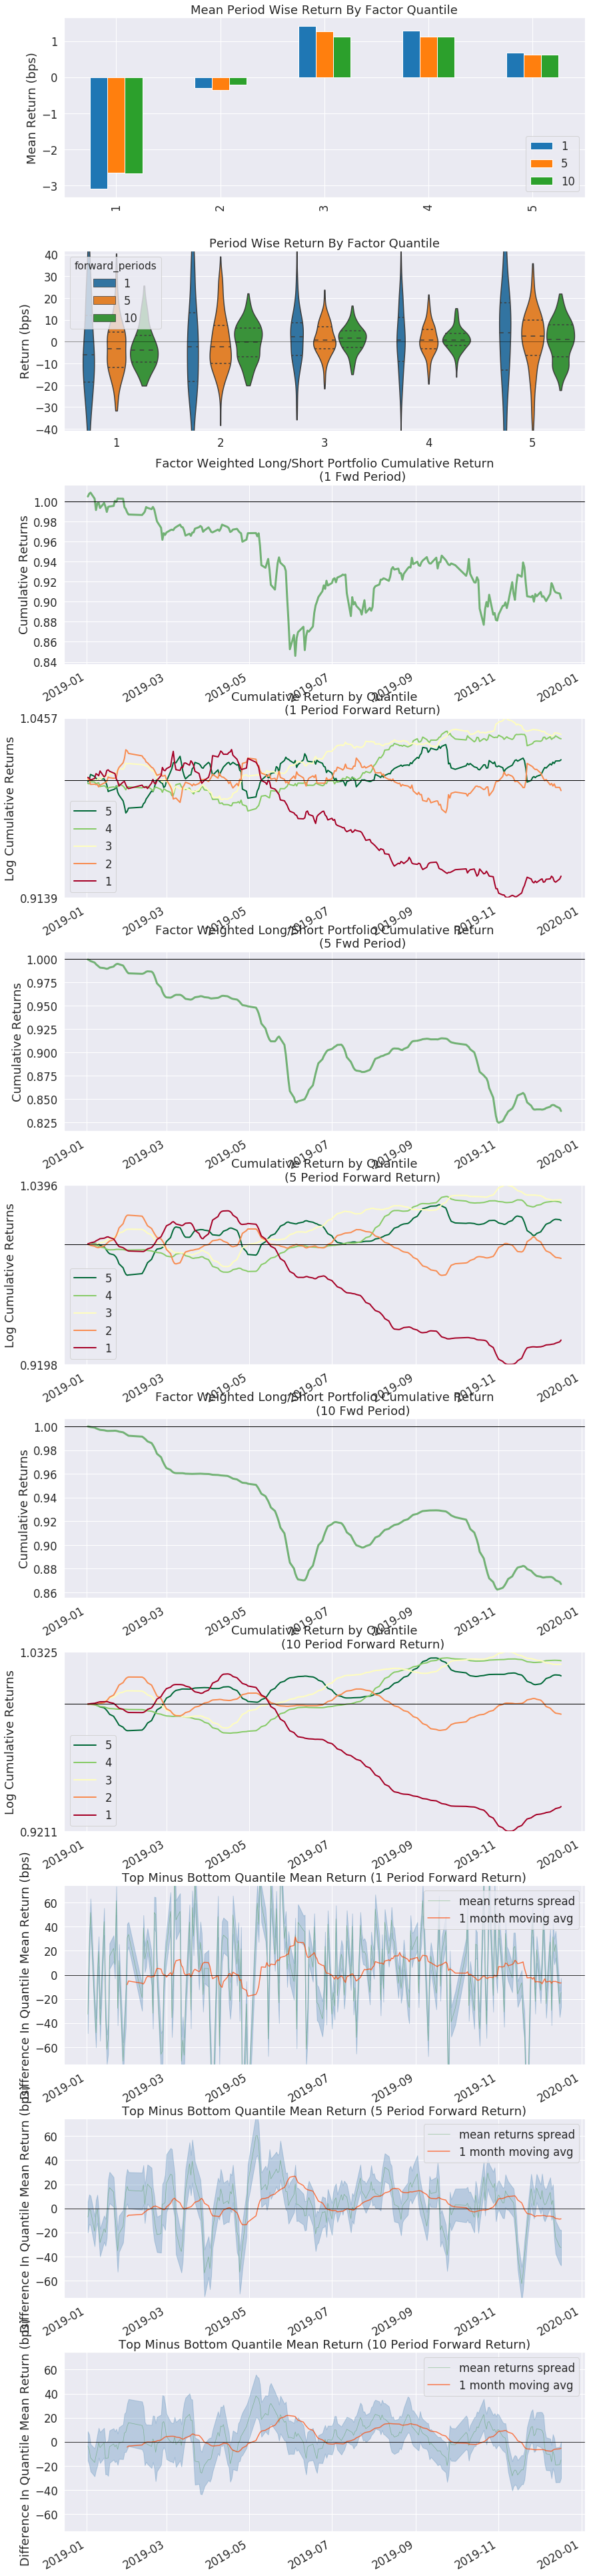

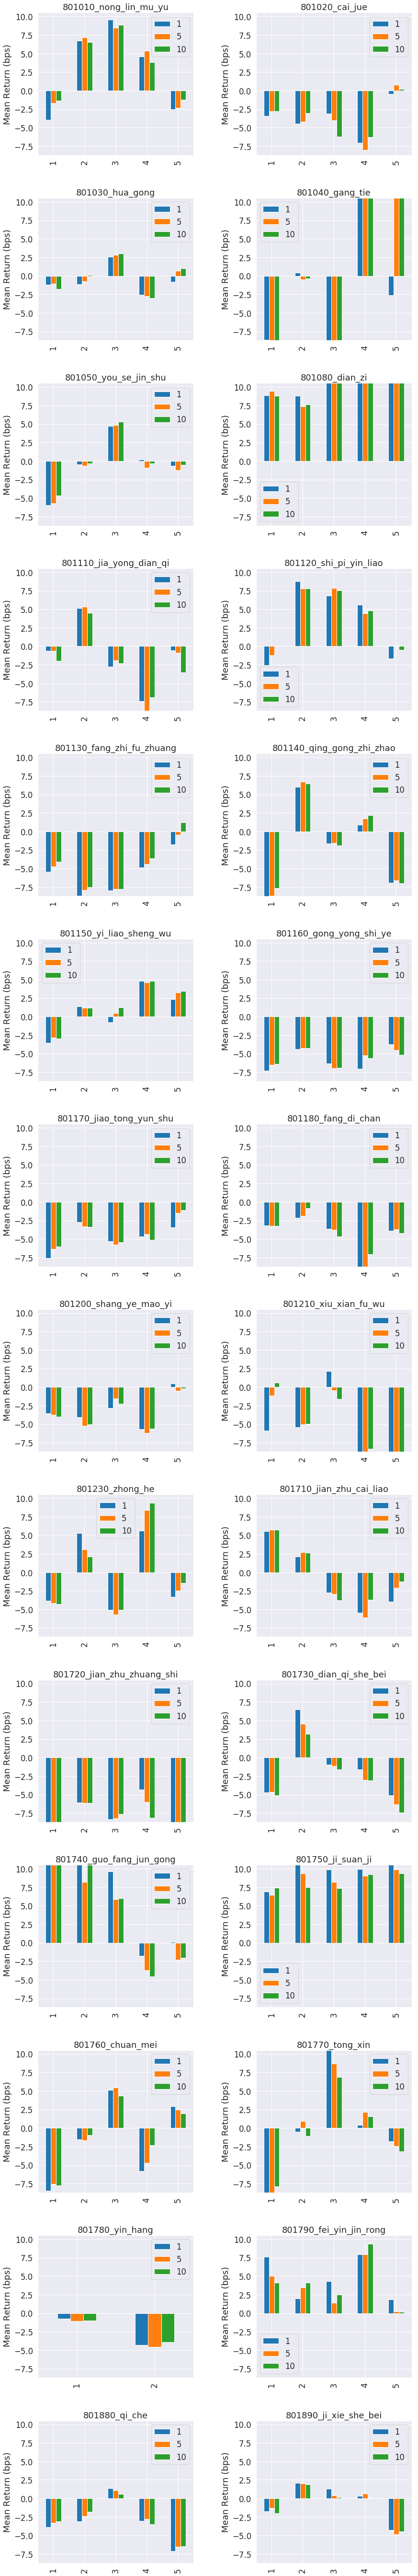

In [33]:
#因子收益率（方向性）画图结果
tears.create_returns_tear_sheet(factor_return,by_group=True)

In [37]:
#进行ic分析
ic = performance.factor_information_coefficient(factor_return)
ic.head()

,1,5,10
date,,,
2019-01-02,-0.047751,-0.039717,-0.036619
2019-01-03,0.016814,0.013133,-0.046914
2019-01-04,0.105702,0.018850,-0.104274
2019-01-07,-0.062994,-0.095453,-0.128227
2019-01-08,-0.092848,-0.039273,-0.100956


In [39]:
#ic的平均值
b=ic[1].mean()
print('ic的平均值: = '+str(b))

ic的平均值: = -0.001013299765488127


In [40]:
#ic>0.02的比例
a=ic.iloc[:,0]
print('ic>0.02的比例: = '+str(len(a[a>0.02])/len(a)))

ic>0.02的比例: = 0.4444444444444444


In [41]:
#ic标准差
c=ic[1].std()
print('ic标准差: = '+str(c))

ic标准差: = 0.07404164544854938


In [42]:
#IR信息比率值
d=b/c
print('IR信息比率值: = '+str(d))

IR信息比率值: = -0.013685538177190516


array([AxesSubplot(0.125,0.125;0.227941x0.755),
       AxesSubplot(0.398529,0.125;0.227941x0.755),
       AxesSubplot(0.672059,0.125;0.227941x0.755)], dtype=object)

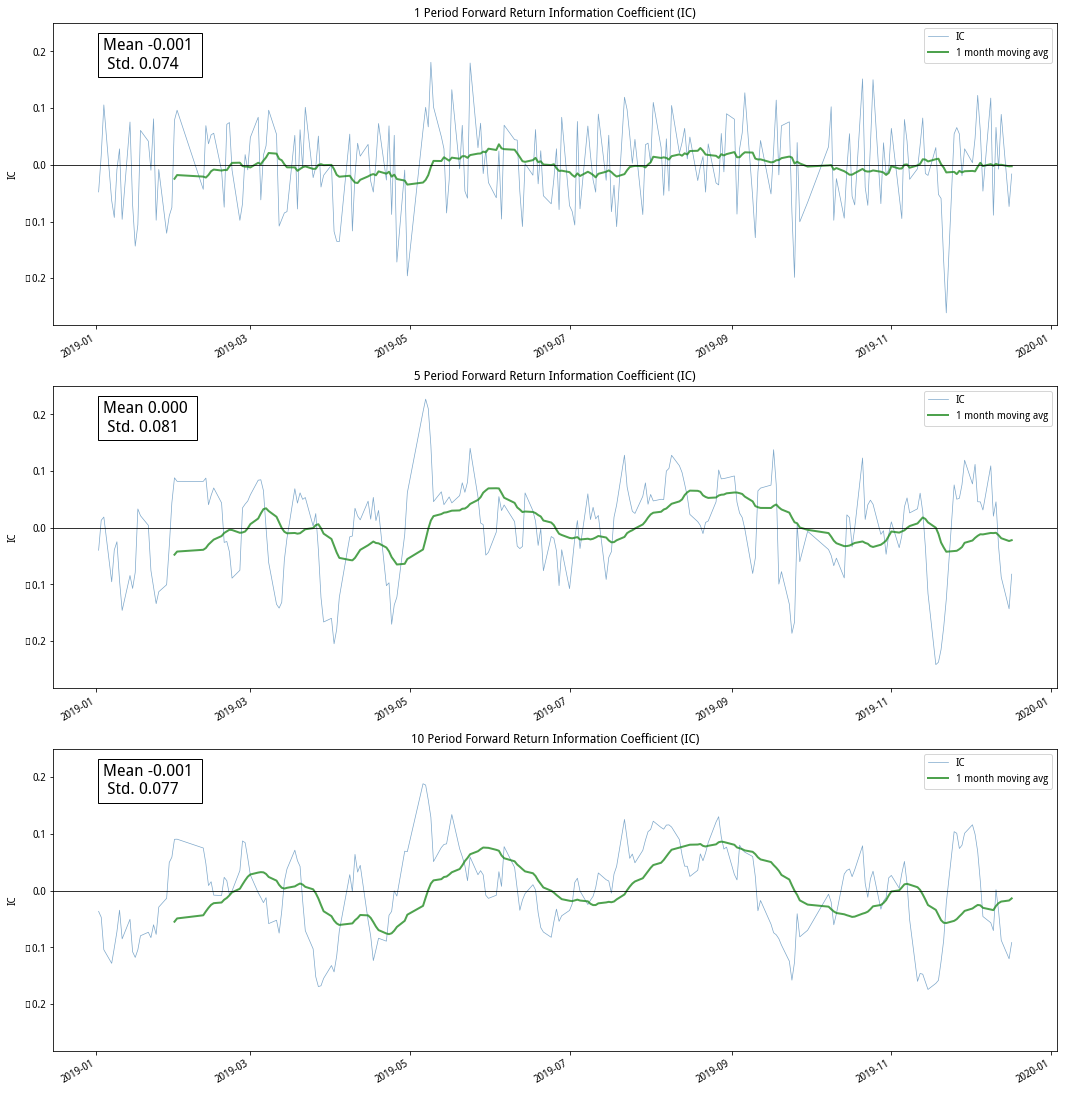

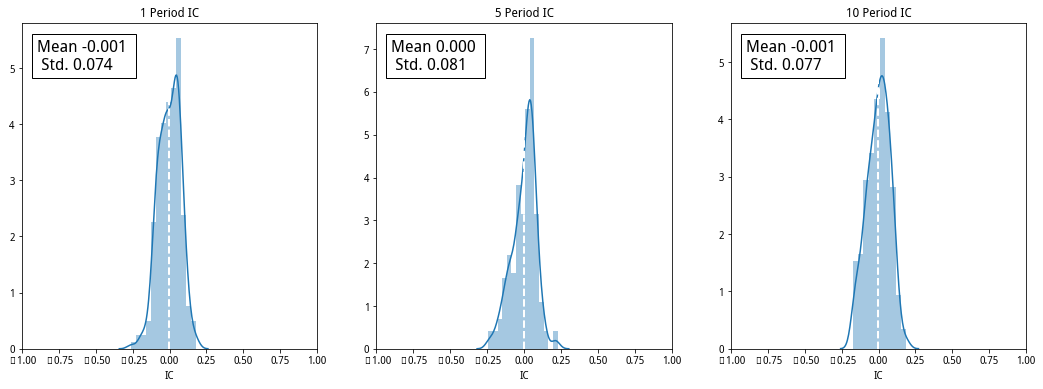

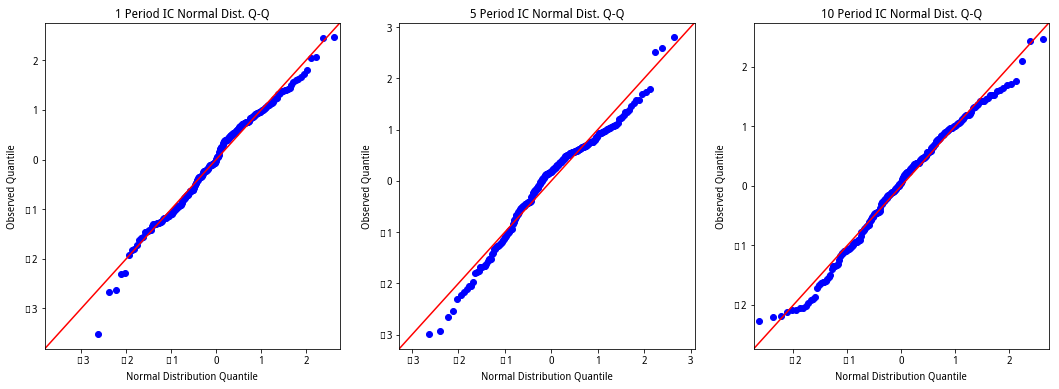

In [43]:
#画图
plotting.plot_ic_ts(ic)
plotting.plot_ic_hist(ic)
plotting.plot_ic_qq(ic)

## 因子 IC 分析

Information Analysis


,1,5,10
IC Mean,-0.001,0.000,-0.001
IC Std.,0.074,0.081,0.077
Risk-Adjusted IC,-0.014,0.004,-0.008
t-stat(IC),-0.209,0.063,-0.120
p-value(IC),0.834,0.950,0.905
IC Skew,-0.291,-0.496,-0.224
IC Kurtosis,-0.031,0.315,-0.510


/opt/conda/lib/python3.6/site-packages/alphalens/performance.py:115: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  grouper.append(pd.TimeGrouper(by_time))


<Figure size 432x288 with 0 Axes>

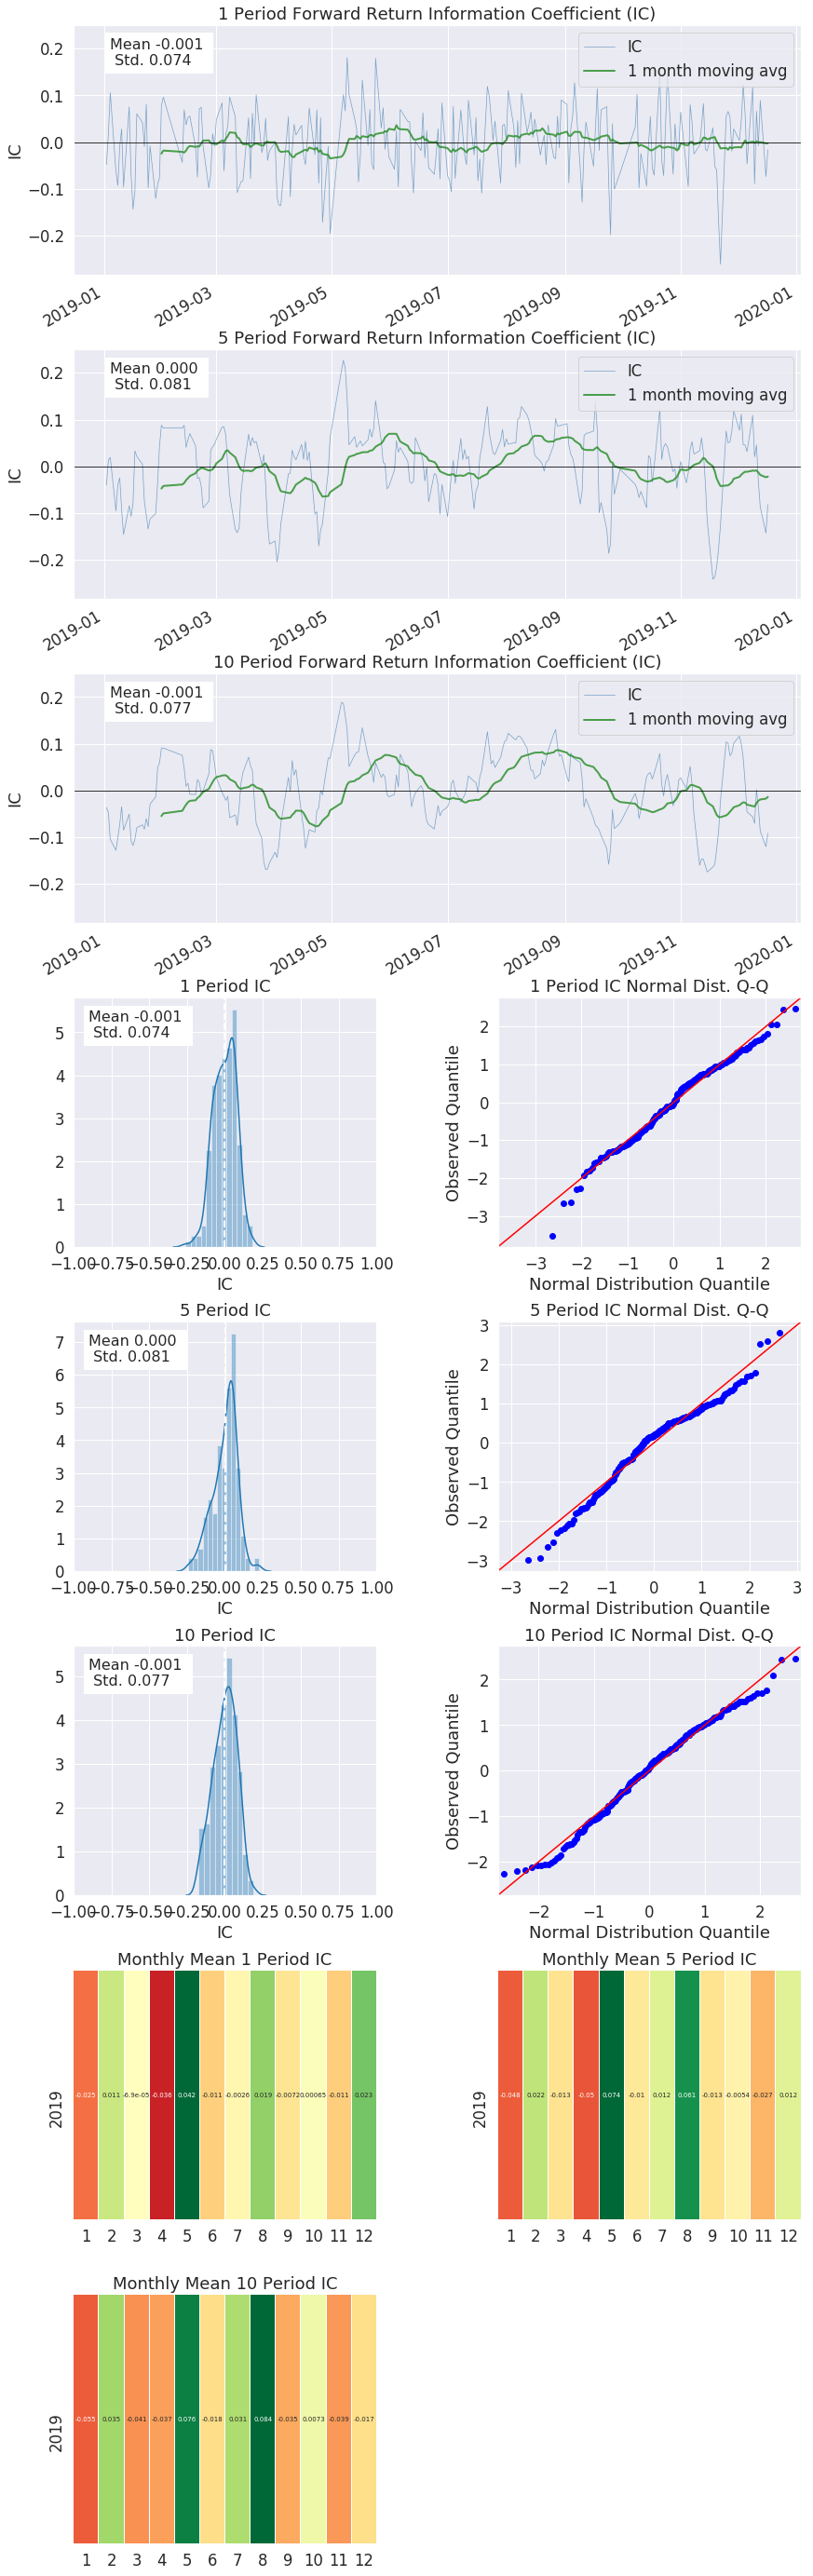

In [44]:
tears.create_information_tear_sheet(factor_return)

## 因子换手率分析

这里的换手率指的是单边的成分股的调整个数占比

Turnover Analysis


,1,5,10
Quantile 1 Mean Turnover,0.008,0.025,0.044
Quantile 2 Mean Turnover,0.020,0.051,0.078
Quantile 3 Mean Turnover,0.033,0.081,0.123
Quantile 4 Mean Turnover,0.032,0.082,0.126
Quantile 5 Mean Turnover,0.015,0.044,0.072


,1,5,10
Mean Factor Rank Autocorrelation,0.996,0.979,0.957


<Figure size 432x288 with 0 Axes>

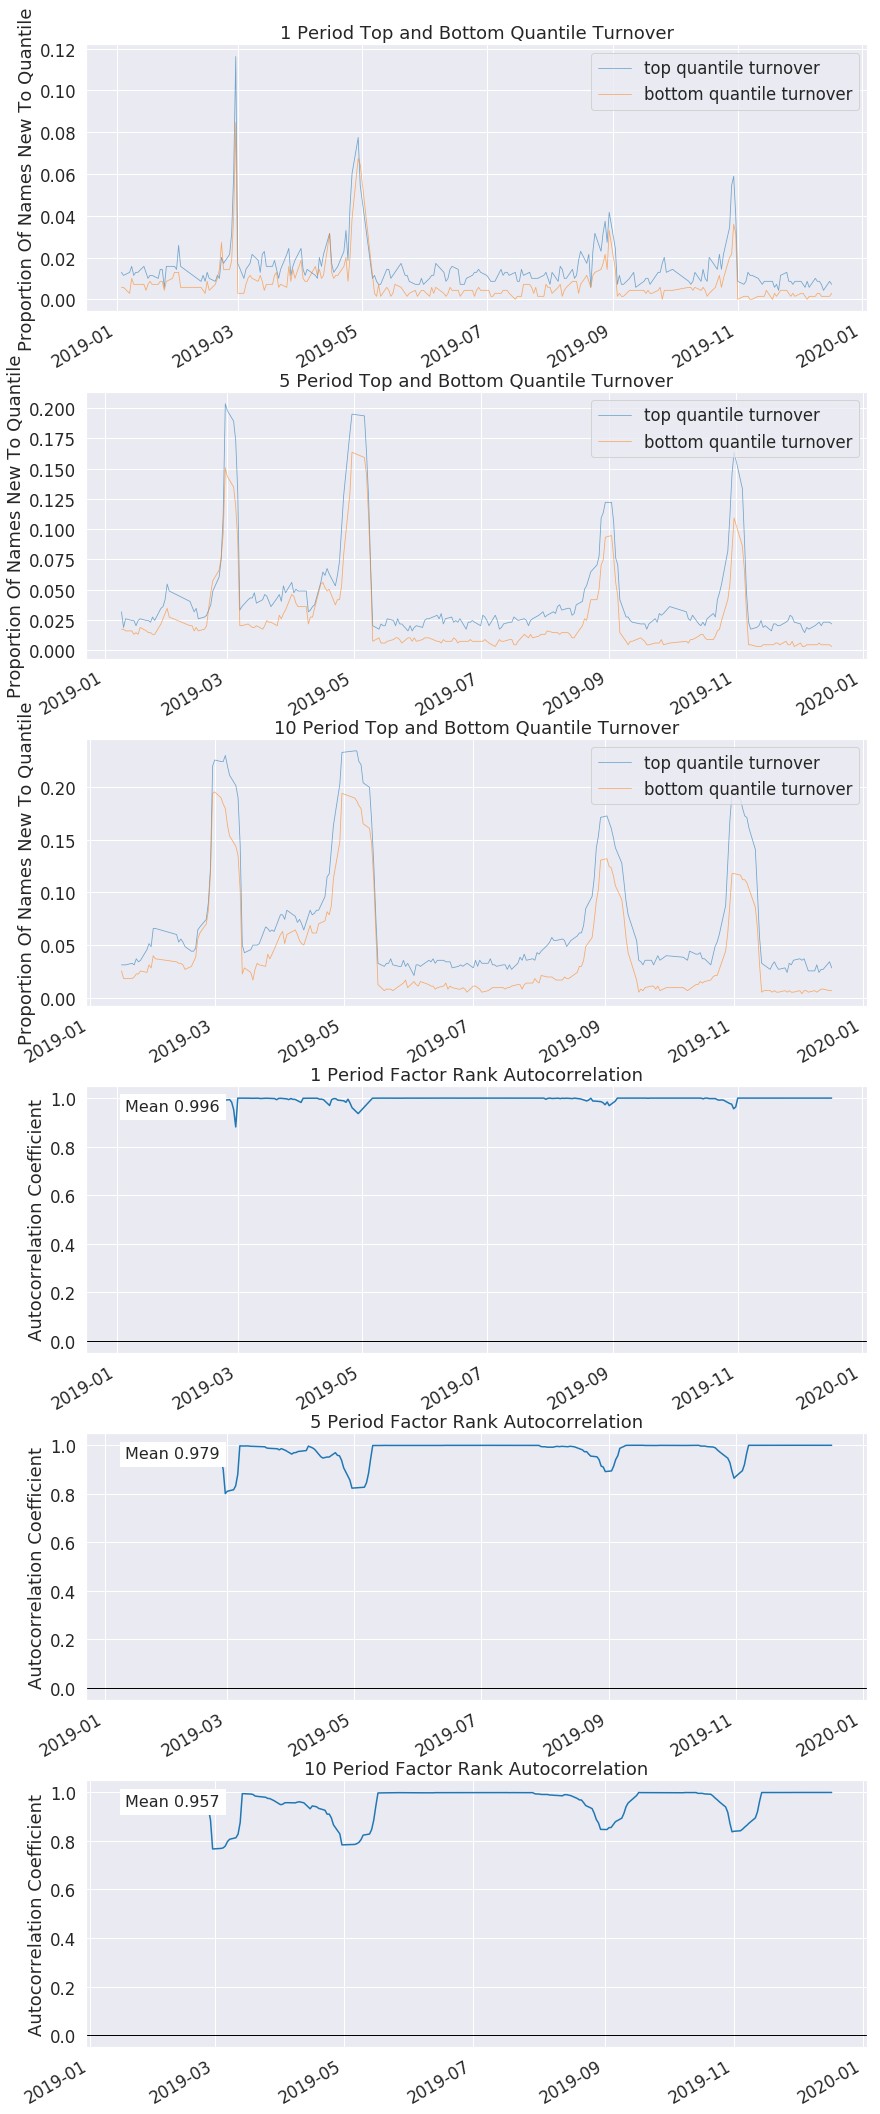

In [45]:
tears.create_turnover_tear_sheet(factor_return)